# 自然语言推断：使用注意力

我们在`sec_natural-language-inference-and-dataset`中介绍了自然语言推断任务和SNLI数据集。鉴于许多模型都是基于复杂而深度的架构，Parikh等人提出用注意力机制解决自然语言推断问题，并称之为“可分解注意力模型”`Parikh.Tackstrom.Das.ea.2016`。这使得模型没有循环层或卷积层，在SNLI数据集上以更少的参数实现了当时的最佳结果。本节将描述并实现这种基于注意力的自然语言推断方法（使用MLP），如`fig_nlp-map-nli-attention`中所述。

![将预训练GloVe送入基于注意力和MLP的自然语言推断架构](../img/nlp-map-nli-attention.svg)

## 模型

与保留前提和假设中词元的顺序相比，我们可以将一个文本序列中的词元与另一个文本序列中的每个词元对齐，然后比较和聚合这些信息，以预测前提和假设之间的逻辑关系。与机器翻译中源句和目标句之间的词元对齐类似，前提和假设之间的词元对齐可以通过注意力机制灵活地完成。

![利用注意力机制进行自然语言推断](../img/nli-attention.svg)

`fig_nli_attention`描述了使用注意力机制的自然语言推断方法。从高层次上讲，它由三个联合训练的步骤组成：对齐、比较和汇总。我们将在下面一步一步地对它们进行说明。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 注意（Attending）

第一步是将一个文本序列中的词元与另一个序列中的每个词元对齐。假设前提是“我确实需要睡眠”，假设是“我累了”。由于语义上的相似性，我们不妨将假设中的“我”与前提中的“我”对齐，将假设中的“累”与前提中的“睡眠”对齐。同样，我们可能希望将前提中的“我”与假设中的“我”对齐，将前提中的“需要”和“睡眠”与假设中的“累”对齐。请注意，这种对齐是使用加权平均的“软”对齐，其中理想情况下较大的权重与要对齐的词元相关联。为了便于演示，`fig_nli_attention`以“硬”对齐的方式显示了这种对齐方式。

现在，我们更详细地描述使用注意力机制的软对齐。用 $\mathbf{A} = (\mathbf{a}_1, \ldots, \mathbf{a}_m)$ 和 $\mathbf{B} = (\mathbf{b}_1, \ldots, \mathbf{b}_n)$ 表示前提和假设，其词元数量分别为 $m$ 和 $n$，其中 $\mathbf{a}_i, \mathbf{b}_j \in \mathbb{R}^{d}$（$i = 1, \ldots, m, j = 1, \ldots, n$）是 $d$ 维的词向量。对于软对齐，我们将注意力权重 $e_{ij} \in \mathbb{R}$ 计算为：

$$e_{ij} = f(\mathbf{a}_i)^\top f(\mathbf{b}_j)$$

其中函数 $f$ 是在下面的`mlp`函数中定义的多层感知机。输出维度 $f$ 由`mlp`的`num_hiddens`参数指定。

In [2]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))

    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
        
    return nn.Sequential(*net)

值得注意的是，在`eq_nli_e`中，$f$ 分别输入 $\mathbf{a}_i$ 和 $\mathbf{b}_j$，而不是将它们一对放在一起作为输入。这种*分解* 技巧导致 $f$ 只有 $m + n$ 个次计算（线性复杂度），而不是 $mn$ 次计算（二次复杂度）。

对`eq_nli_e`中的注意力权重进行规范化，我们计算假设中所有词元向量的加权平均值，以获得假设的表示，该假设与前提中索引 $i$ 的词元进行软对齐：

$$
\boldsymbol{\beta}_i = \sum_{j=1}^{n}\frac{\exp(e_{ij})}{ \sum_{k=1}^{n} \exp(e_{ik})} \mathbf{b}_j
$$

同样，我们计算假设中索引为 $j$ 的每个词元与前提词元的软对齐：

$$
\boldsymbol{\alpha}_j = \sum_{i=1}^{m}\frac{\exp(e_{ij})}{ \sum_{k=1}^{m} \exp(e_{kj})} \mathbf{a}_i
$$

下面，我们定义`Attend`类来计算 假设（`beta`）与输入前提`A`的软对齐 以及 前提（`alpha`）与输入假设`B`的软对齐。

模块接受两个序列 A 和 B，然后通过多层感知机（MLP）和点积运算对它们进行相似度计算和对齐。目的是将一个序列中的词元“软对齐”到另一个序列中。

In [3]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # A/B 的形状：（批量大小，序列 A/B 的词元数，embed_size）
        # f_A/f_B 的形状：（批量大小，序列 A/B 的词元数，num_hiddens）
        f_A = self.f(A)
        f_B = self.f(B)

        # e 是通过 f_A 和 f_B 的点积得到的相似度矩阵，用于度量序列 A 和 B 中词元之间的相似性
        # e 的形状：（批量大小，序列 A 的词元数，序列 B 的词元数）
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))  # batch matrix multiplication -- (序列 A 的词元数，num_hiddens)*（num_hiddens，序列 B 的词元数）

        # beta 的形状：（批量大小，序列 A 的词元数，embed_size）
        # 意味着序列 B 被软对齐到序列 A 的每个词元（beta 的第 1 个维度）
        beta = torch.bmm(F.softmax(e, dim=-1), B)  # dim=-1 表示在最后一个维度进行 softmax

        # alpha 的形状：（批量大小，序列 B 的词元数，embed_size）
        # 意味着序列 A 被软对齐到序列 B 的每个词元（alpha 的第 1 个维度）
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)

        return beta, alpha

### 比较

在下一步中，我们将一个序列中的词元与与该词元软对齐的另一个序列进行比较。请注意，在软对齐中，一个序列中的所有词元（尽管可能具有不同的注意力权重）将与另一个序列中的词元进行比较。为便于演示，`fig_nli_attention`对词元以“硬”的方式对齐。例如，上述的 *注意*（attending）步骤确定前提中的“need”和“sleep”都与假设中的“tired”对齐，则将对“疲倦-需要睡眠”进行比较。

在比较步骤中，我们将来自一个序列的词元的连结（运算符$[\cdot, \cdot]$）和来自另一序列的对齐的词元送入函数$g$（一个多层感知机）：

$$\mathbf{v}_{A,i} = g([\mathbf{a}_i, \boldsymbol{\beta}_i]), i = 1, \ldots, m\\ \mathbf{v}_{B,j} = g([\mathbf{b}_j, \boldsymbol{\alpha}_j]), j = 1, \ldots, n$$


在`eq_nli_v_ab`中，
- $\mathbf{v}_{A,i}$ 是指，所有假设中的词元与前提中词元 $i$ 软对齐，再与词元 $i$ 的比较。
- $\mathbf{v}_{B,j}$ 是指，所有前提中的词元与假设中词元 $i$ 软对齐，再与词元 $i$ 的比较。

下面的`Compare`个类定义了比较步骤。

In [4]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        # 连结 A 与 beta 计算 V_A
        V_A = self.g(torch.cat([A, beta], dim=2))
        # 连结 B 与 alpha 计算 V_B
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

### 聚合

现在我们有两组比较向量 $\mathbf{v}_{A,i}$（$i = 1, \ldots, m$）和 $\mathbf{v}_{B,j}$（$j = 1, \ldots, n$）。在最后一步中，我们将聚合这些信息以推断逻辑关系。我们首先求和这两组比较向量：

$$
\mathbf{v}_A = \sum_{i=1}^{m} \mathbf{v}_{A,i}, \quad \mathbf{v}_B = \sum_{j=1}^{n}\mathbf{v}_{B,j}
$$

接下来，我们将两个求和结果的连结提供给函数 $h$（一个多层感知机），以获得逻辑关系的分类结果：

$$
\hat{\mathbf{y}} = h([\mathbf{v}_A, \mathbf{v}_B])
$$

聚合步骤在以下`Aggregate`类中定义。

In [5]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # 对两组比较向量分别求和
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # 将两个求和结果的连结送到多层感知机中
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

### 整合代码

通过将注意步骤、比较步骤和聚合步骤组合在一起，我们定义了可分解注意力模型来联合训练这三个步骤。

In [6]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        # 计算输入句子之间的注意力表示
        self.attend = Attend(num_inputs_attend, num_hiddens)
        # 比较前提和假设的对齐特征
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # 最终聚合生成模型的输出分类（有 3 种可能的输出：蕴涵、矛盾和中性）
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)

        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

## 训练和评估模型

现在，我们将在SNLI数据集上对定义好的可分解注意力模型进行训练和评估。我们从读取数据集开始。

### 读取数据集

我们使用`sec_natural-language-inference-and-dataset`中定义的函数下载并读取SNLI数据集。批量大小和序列长度分别设置为$256$和$50$。

In [7]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


### 创建模型

我们使用预训练好的 100 维 GloVe 嵌入来表示输入词元。我们将向量 $\mathbf{a}_i$ 和 $\mathbf{b}_j$ 在`eq_nli_e`中的维数预定义为 100。`eq_nli_e`中的函数 $f$ 和`eq_nli_v_ab`中的函数 $g$ 的输出维度被设置为 200。然后我们创建一个模型实例，初始化它的参数，并加载 GloVe 嵌入来初始化输入词元的向量。

In [8]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus_mps()  # mps 加速
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

### 训练和评估模型

与`sec_multi_gpu`中接受单一输入（如文本序列或图像）的`split_batch`函数不同，我们定义了一个`split_batch_multi_inputs`函数以小批量接受多个输入，如前提和假设。

现在我们可以在SNLI数据集上训练和评估模型。


loss 0.556, train acc 0.777, test acc 0.813
1294.2 examples/sec on [device(type='mps', index=0)]


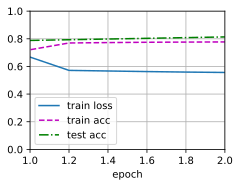

In [10]:
lr, num_epochs = 0.001, 2
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### 使用模型

最后，定义预测函数，输出一对前提和假设之间的逻辑关系。

In [15]:
#@save
def predict_snli(net, vocab, premise, hypothesis):
    """预测前提和假设之间的逻辑关系"""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu_mps())  # mps 加速
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu_mps())  # mps 加速
    label = torch.argmax(net([premise.reshape((1, -1)), hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 else 'neutral'

我们可以使用训练好的模型来获得对示例句子的自然语言推断结果。

In [16]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

## 小结

* 可分解注意模型包括三个步骤来预测前提和假设之间的逻辑关系：注意、比较和聚合。
* 通过注意力机制，我们可以将一个文本序列中的词元与另一个文本序列中的每个词元对齐，反之亦然。这种对齐是使用加权平均的软对齐，其中理想情况下较大的权重与要对齐的词元相关联。
* 在计算注意力权重时，分解技巧会带来比二次复杂度更理想的线性复杂度。
* 我们可以使用预训练好的词向量作为下游自然语言处理任务（如自然语言推断）的输入表示。

## 练习

1. 使用其他超参数组合训练模型，能在测试集上获得更高的准确度吗？
2. 自然语言推断的可分解注意模型的主要缺点是什么？
3. 假设我们想要获得任何一对句子的语义相似级别（例如，0～1之间的连续值）。我们应该如何收集和标注数据集？请尝试设计一个有注意力机制的模型。

[Discussions](https://discuss.d2l.ai/t/5728)
